# Loans EDA

## Fields description

`profile_id` is the unique identificator of a customer. One customer could have many loans.

`app_id` is the unique identificator of an application. One customer could have many applications and not every application results in a loan.

`loan` is the unique identificator of a loan.

`begin_date` is the date when a loan was granted to a client.

`end_date` is the planned date of repayment according to loan's schedule. If a loan was prolongued this date will account for the last planned date of repayment.

`amount` is the amount granted to the a client when a loan was originated.

`product` is the internal classification of financial structure of a loan as a product. **START** corresponds to the product with initial commission and then some grace period for interest. **START_11** as oposite has no initial commission by incorporates intrest rate form the vary begining. Total loan overpayment is the same for both products.

`status` is the status of a loan. Possible values are: **OVERDUE**, **REPAID**, **CLOSED**. There is only technical difference between **REPAID** and **CLOSED**. Thus status **REPAID** can be treated as **CLOSED** for the purpose of this analysis.

`lodging_cnt` accounts for the number of prolongations of a loan.

`repayment_ratio` is the total amount repayed by a customer divided by begin amount granted to that customer in boundaries of a single loan.

## Additional notes from the owners of the dataset

1. Loans granted before 2018-06-01 where technicaly test loans and should be omited for the purpose of this analysis.

2. For the loans granted from 2018-06-01 till February 2019 loan amount was limited at 2 UAHk. Somewhere at the end of February 2019 the cap was raised to 3 UAHk for new clients ans 4 UAHk for existing clients.

3. During autumn 2018 they conducted kind of test granting some bad customers 100 UAH loans instead of rejecting their applications.

4. During February-March 2019 they conducted kind of another test granting some bad customers 500 UAH loans instead of rejecting their applications.

5. Marketing activity was different during different months. This data can't be shared within this project.

6. It's suggested to treat loan as **GOOD** if it was repayed 90% of the begin amount or more and to treat loan as **GOOD** if it was repayed 10% of the begin amount or less. It's hard to classify loans if the repayment ratio is between 10% and 90%. Loans can be classified only 90 days after the date of origination.

## Load data

In [6]:
# load libraries

import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# load data

df_loans = pd.read_csv('../data/raw/dr_loans.csv')
df_loans.head()

,profile_id,app_id,loan,begin_date,end_date,amount,product,status,lodging_cnt,repayment_ratio
0,158618,848153,34275,2020-01-16,2020-02-25,3500.0,START_11,CLOSED,1,1.486
1,709513,509688,21025,2019-06-14,2019-06-28,700.0,START_11,CLOSED,0,1.000
2,690248,518539,21232,2019-06-19,2019-06-30,2000.0,START_11,CLOSED,0,1.054
3,753344,755195,30938,2019-11-23,2019-12-07,700.0,START_11,CLOSED,0,1.036
4,416384,393817,17844,2019-04-09,2019-05-04,2300.0,START_11,CLOSED,1,1.180


In [8]:
# convert 'begin_date' and 'end_date' fields to datetime type
df_loans.loc[:,['begin_date', 'end_date']] = df_loans[['begin_date', 'end_date']].transform(pd.to_datetime)

# drop test loans and "young" loans
df_loans = df_loans[(df_loans['begin_date'] >= '2018-06-01') & (df_loans['begin_date'] < '2020-01-01')]

# simplify status
df_loans['status'] = df_loans['status'].transform(lambda x: 'CLOSED' if x == 'REPAID' else x)


In [9]:
# Calculate loan number for each customer
df_loans['loan_num'] = df_loans.groupby('profile_id')['begin_date'].rank(method="first", ascending=True).astype(int)

# Classify loans
report_day = pd.to_datetime('2020-04-07')
df_loans['can_be_bad'] = df_loans['begin_date'].apply(lambda d: (report_day - d) > timedelta(days=90))
df_loans['bad'] = df_loans['repayment_ratio'].apply(lambda rr: True if rr < 0.1 else (False if rr > 0.9 else np.NaN))

# Filter only loans apropriate for model input
df_loans = df_loans[df_loans['can_be_bad'] & df_loans['bad'].notnull()]
df_loans.head()

,profile_id,app_id,loan,begin_date,end_date,amount,product,status,lodging_cnt,repayment_ratio,loan_num,can_be_bad,bad
1,709513,509688,21025,2019-06-14,2019-06-28,700.0,START_11,CLOSED,0,1.000,1,True,False
2,690248,518539,21232,2019-06-19,2019-06-30,2000.0,START_11,CLOSED,0,1.054,3,True,False
3,753344,755195,30938,2019-11-23,2019-12-07,700.0,START_11,CLOSED,0,1.036,17,True,False
4,416384,393817,17844,2019-04-09,2019-05-04,2300.0,START_11,CLOSED,1,1.180,2,True,False
5,767257,580393,23343,2019-07-31,2019-08-07,3000.0,START_11,CLOSED,0,1.108,2,True,False


## Basic overview

In [11]:
df_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12593 entries, 1 to 13931
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   profile_id       12593 non-null  int64         
 1   app_id           12593 non-null  int64         
 2   loan             12593 non-null  int64         
 3   begin_date       12593 non-null  datetime64[ns]
 4   end_date         12593 non-null  datetime64[ns]
 5   amount           12593 non-null  float64       
 6   product          12593 non-null  object        
 7   status           12593 non-null  object        
 8   lodging_cnt      12593 non-null  int64         
 9   repayment_ratio  12593 non-null  float64       
 10  loan_num         12593 non-null  int64         
 11  can_be_bad       12593 non-null  bool          
 12  bad              12593 non-null  object        
dtypes: bool(1), datetime64[ns](2), float64(2), int64(5), object(3)
memory usage: 1.3+ MB


In [12]:
df_loans.drop(['profile_id', 'app_id', 'loan'], axis='columns').describe()

,amount,lodging_cnt,repayment_ratio,loan_num
count,12593.000000,12593.000000,12593.000000,12593.000000
mean,1919.725244,0.298658,1.130820,1.727944
std,1088.057509,0.966306,0.825503,1.480065
min,100.000000,0.000000,0.000000,1.000000
25%,1000.000000,0.000000,0.966667,1.000000
50%,2000.000000,0.000000,1.198000,1.000000
75%,3000.000000,0.000000,1.486000,2.000000
max,4000.000000,19.000000,7.395910,23.000000


In [13]:
df_loans['begin_date'].describe()

count                   12593
unique                    577
top       2019-03-01 00:00:00
freq                      252
first     2018-06-03 00:00:00
last      2019-12-31 00:00:00
Name: begin_date, dtype: object

In [14]:
df_loans['end_date'].describe()

count                   12593
unique                    599
top       2019-03-15 00:00:00
freq                      139
first     2018-06-14 00:00:00
last      2020-02-27 00:00:00
Name: end_date, dtype: object

In [15]:
df_loans['product'].value_counts()

START_11    9310
START       3283
Name: product, dtype: int64

In [16]:
df_loans['status'].value_counts()

CLOSED     9137
OVERDUE    3456
Name: status, dtype: int64

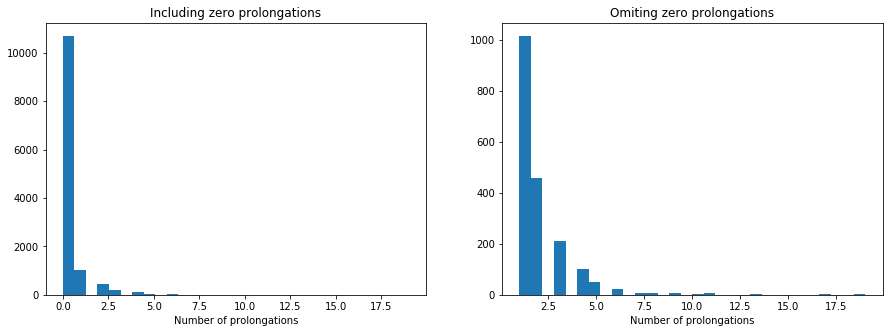

In [17]:
plt.subplots(1, 2, figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(df_loans['lodging_cnt'], bins = 30)
plt.xlabel('Number of prolongations')
plt.title('Including zero prolongations')
plt.subplot(1,2,2)
plt.hist(df_loans[df_loans['lodging_cnt'] > 0]['lodging_cnt'], bins = 30)
plt.xlabel('Number of prolongations')
plt.title('Omiting zero prolongations')
plt.show()

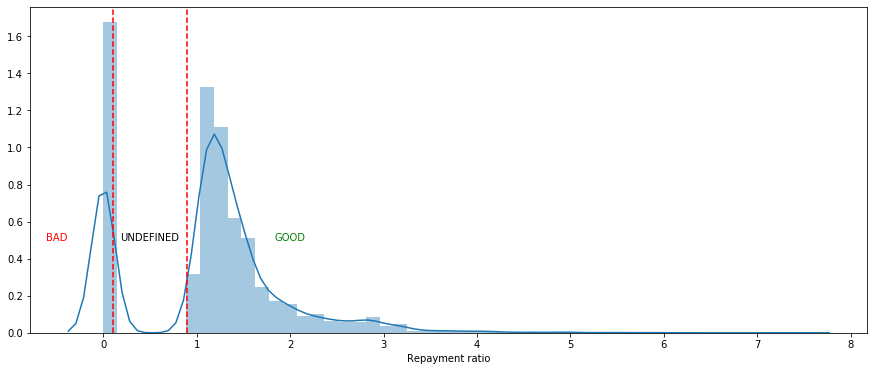

In [18]:
plt.figure(figsize=(15,6))
sns.distplot(df_loans['repayment_ratio'])
plt.axvline(x=0.1, linestyle='--', color='r')
plt.axvline(x=0.9, linestyle='--', color='r')
plt.text(x=-0.5, y=0.5, s='BAD', color='r', horizontalalignment='center')
plt.text(x=0.5, y=0.5, s='UNDEFINED', color='k', horizontalalignment='center')
plt.text(x=2, y=0.5, s='GOOD', color='g', horizontalalignment='center')
plt.xlabel('Repayment ratio')
plt.show()

<u>Thoughts</u>

Looks like it's better to investigate further who are those clients with repayments ratio from 10% to 60%.

In [19]:
(df_loans.groupby('profile_id')
         .agg(loans=pd.NamedAgg(column='loan', aggfunc='count'))
         .reset_index()
         .groupby('loans')
         .agg(profiles=pd.NamedAgg(column='profile_id', aggfunc='count'))
         .head()
)

,profiles
loans,
1,5501
2,1539
3,541
4,226
5,110


<u>Thoughts</u>
    
- most of the clients takes only one loan
- some clients recieves 2-5 loans
- only a few clients gets 6 and more loans

It looks natural to devide clients into 3 groups:
    
- `1st` loan
- `2nd` loan
- `3rd+` loan

In [20]:
(df_loans.groupby('profile_id')
         .agg(loans=pd.NamedAgg(column='loan', aggfunc='count'))
         .reset_index()
         .groupby('loans')
         .agg(profiles=pd.NamedAgg(column='profile_id', aggfunc='count'))
         .reset_index()
         .transform(func={'loans': (lambda x: '3+' if x >= 3 else str(x)), 'profiles': (lambda x: x)})
         .groupby('loans')
         .agg(profiles=pd.NamedAgg(column='profiles', aggfunc='sum'))
)

,profiles
loans,
1,5501
2,1539
3+,1000


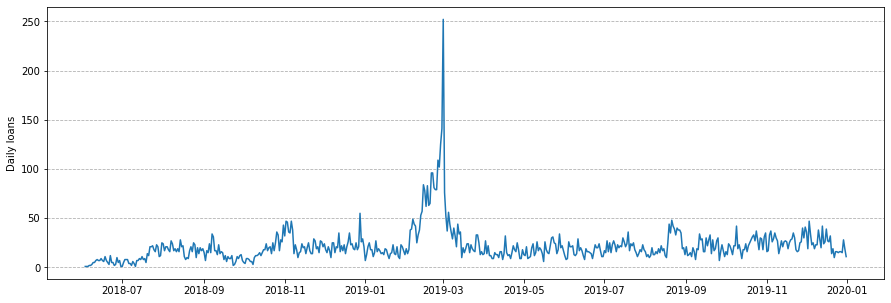

In [21]:
df_by_day = (df_loans['begin_date'].value_counts().sort_index())

plt.figure(figsize=(15,5))
plt.plot(df_by_day.index, df_by_day, zorder=2)
plt.ylabel('Daily loans')
plt.grid(axis='y', linestyle='--')
plt.show()

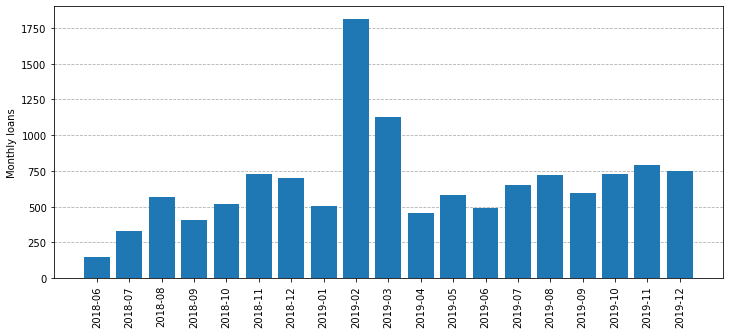

In [22]:
df_by_month = (df_loans['begin_date']
    .dt.strftime('%Y-%m')
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(12,5))
plt.bar(df_by_month.index, df_by_month, zorder=2)
plt.xticks(rotation='vertical')
plt.ylabel('Monthly loans')
plt.grid(axis='y', linestyle='--')
plt.show()

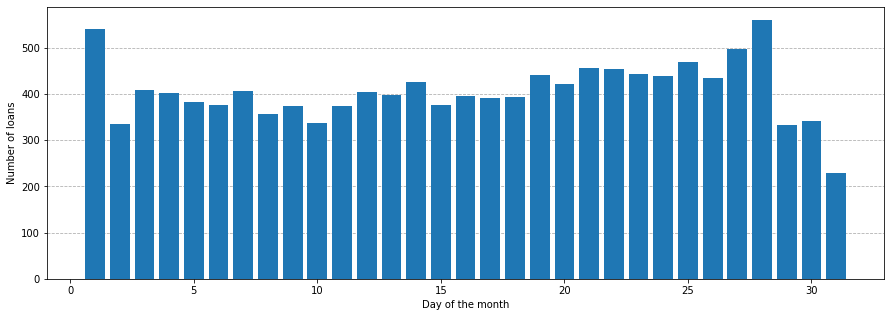

In [23]:
df_by_mday = (df_loans['begin_date']
    .dt.day
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(15,5))
plt.bar(df_by_mday.index, df_by_mday, zorder=2)
plt.xlabel('Day of the month')
plt.ylabel('Number of loans')
plt.grid(axis='y', linestyle='--')
plt.show()

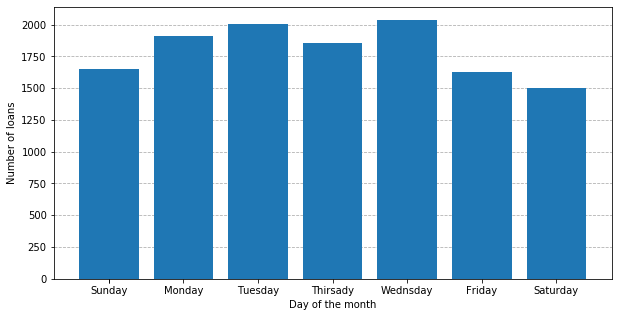

In [24]:
df_by_wday = (df_loans['begin_date']
    .dt.weekday
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(10,5))
plt.bar(df_by_wday.index, df_by_wday, zorder=2)
plt.xticks(ticks=[0,1,2,3,4,5,6,0], labels=['Sunday','Monday','Tuesday','Thirsady','Wednsday','Friday','Saturday'])
plt.xlabel('Day of the month')
plt.ylabel('Number of loans')
plt.grid(axis='y', linestyle='--')
plt.show()

### Percentage of credit status by product

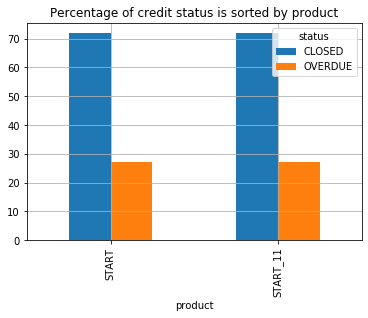

In [33]:
stat_prod_df = pd.DataFrame.copy(df_loans[['status','product']].groupby(['product','status']).size())

# conbert data to percentages
perc1 = 100/(stat_prod_df[0]+stat_prod_df[1])
perc2 = 100/(stat_prod_df[3]+stat_prod_df[2])
stat_prod_df[0] *=perc1
stat_prod_df[1] *=perc1
stat_prod_df[2] *=perc2
stat_prod_df[3] *=perc2
stat_prod_df.unstack().plot.bar(title=('Percentage of credit status is sorted by product'), grid = True)
plt.show()

'START' product has better predictive model than 'START_11' \
START - 72% closed loans \
START_11 - 67% closed loans

### Loans by amount distribution

In [31]:
amount_df = pd.DataFrame.copy(df_loans.groupby('amount')
         .agg(loans=pd.NamedAgg(column='loan', aggfunc='count'))
         .reset_index()
)

# binning data by amount
bin_labels = ['0-500', '500-1000','1100-1500','1600-2000','2100-2500','2600-3000','3100-3500','3600-4000',]
amount_df['amount_binned'] = pd.qcut(x=amount_df.index, q=8, labels=bin_labels) 

# get bins sum
amount_df = (amount_df.groupby('amount_binned')
         .agg(loans_sum=pd.NamedAgg(column='loans', aggfunc='sum'))
         .reset_index()
)

In [32]:
amount_df

,amount_binned,loans_sum
0,0-500,2080
1,500-1000,1391
2,1100-1500,1458
3,1600-2000,3859
4,2100-2500,358
5,2600-3000,2067
6,3100-3500,105
7,3600-4000,1275


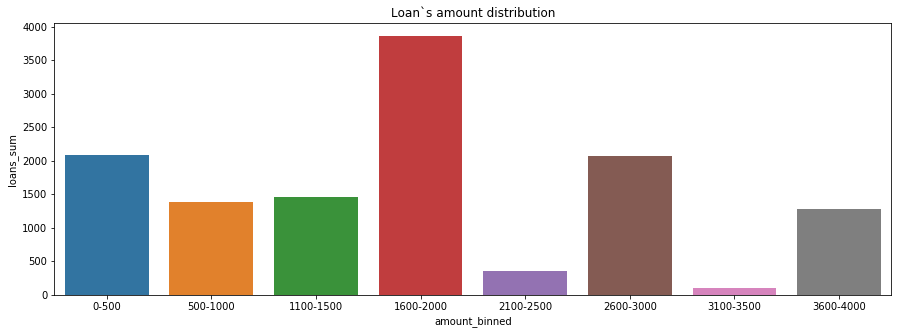

In [34]:
# plot diagram
plt.figure(figsize=(15,5))
ax = sns.barplot(x="amount_binned", y="loans_sum", data=amount_df, ci=None)
plt.title('Loan`s amount distribution')
plt.show()

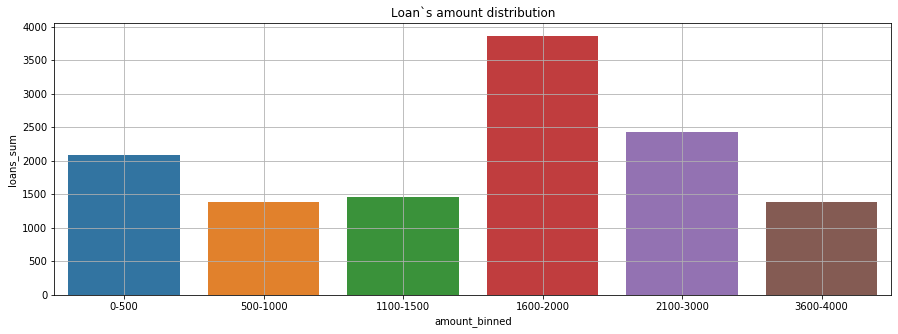

In [35]:
amount_df2 = pd.DataFrame.copy(df_loans.groupby('amount')
         .agg(loans=pd.NamedAgg(column='loan', aggfunc='count'))
         .reset_index()
)

# binning data by amount
cut_labels_4 = ['0-500', '500-1000','1100-1500','1600-2000','2100-3000','3600-4000']
cut_bins = [0, 500, 1000, 1500, 2000, 3000, 4000]
amount_df2['amount_binned'] = pd.cut(amount_df2['amount'], bins=cut_bins, labels=cut_labels_4)

amount_df2 = (amount_df2.groupby('amount_binned')
         .agg(loans_sum=pd.NamedAgg(column='loans', aggfunc='sum'))
         .reset_index()
)


# plot diagram
plt.figure(figsize=(15,5))
ax = sns.barplot(x="amount_binned", y="loans_sum", data=amount_df2, ci=None)
plt.title('Loan`s amount distribution')
plt.grid(True)
plt.show()

during preprocessing can cut amount by 4 or 6 bins \
4 -  ['0-1000','1100-2000','2100-3000','3100-4000'] \
6 - ['0-500', '500-1000','1100-1500','1600-2000','2100-3000','3100-4000']

### Percantages by amount`s bins

In [37]:
binning_by_amount_df = pd.DataFrame.copy(df_loans[['amount', 'status']])

# binning data by amount
cut_labels_4 = ['0-1000','1100-2000','2100-4000']
cut_bins = [0, 1000, 2000, 4000]
binning_by_amount_df['amount_binned'] = pd.cut(binning_by_amount_df['amount'], bins=cut_bins, labels=cut_labels_4)

binning_by_amount_df.head()

,amount,status,amount_binned
1,700.0,CLOSED,0-1000
2,2000.0,CLOSED,1100-2000
3,700.0,CLOSED,0-1000
4,2300.0,CLOSED,2100-4000
5,3000.0,CLOSED,2100-4000


In [38]:
binning_by_amount_df.drop('amount' , axis = 1, inplace = True)

# create two dataframe to calculate percentage
d1 = pd.DataFrame.copy(binning_by_amount_df[binning_by_amount_df['status']=='CLOSED'].groupby('amount_binned')
         .agg(closed_persent=pd.NamedAgg(column='status', aggfunc='count'))
         .reset_index()
)

d2 = pd.DataFrame.copy(binning_by_amount_df.groupby('amount_binned')
         .agg(closed_persent=pd.NamedAgg(column='status', aggfunc='count'))
         .reset_index()
)

d1['closed_persent'] = 100/d2['closed_persent']*d1['closed_persent']
d1

,amount_binned,closed_persent
0,0-1000,75.108038
1,1100-2000,70.434456
2,2100-4000,73.193167


In [39]:
binning_by_amount_df = pd.DataFrame.copy(df_loans[['amount', 'status']])

# binning data by amount
cut_labels_4 = ['0-500', '500-1000','1100-1500','1600-2000','2100-3000','3600-4000']
cut_bins = [0, 500, 1000, 1500, 2000, 3000, 4000]
binning_by_amount_df['amount_binned'] = pd.cut(binning_by_amount_df['amount'], bins=cut_bins, labels=cut_labels_4)

binning_by_amount_df.drop('amount' , axis = 1, inplace = True)

binning_by_amount_df.head()

,status,amount_binned
1,CLOSED,500-1000
2,CLOSED,1600-2000
3,CLOSED,500-1000
4,CLOSED,2100-3000
5,CLOSED,2100-3000


In [40]:
# Percents by another binning

d1 = pd.DataFrame.copy(binning_by_amount_df[binning_by_amount_df['status']=='CLOSED'].groupby('amount_binned')
         .agg(closed_persent=pd.NamedAgg(column='status', aggfunc='count'))
         .reset_index()
)

d2 = pd.DataFrame.copy(binning_by_amount_df.groupby('amount_binned')
         .agg(closed_persent=pd.NamedAgg(column='status', aggfunc='count'))
         .reset_index()
)

d1['closed_persent'] = 100/d2['closed_persent']*d1['closed_persent']
d1

,amount_binned,closed_persent
0,0-500,74.230769
1,500-1000,76.419842
2,1100-1500,73.319616
3,1600-2000,69.344390
4,2100-3000,72.536082
5,3600-4000,74.347826


#### conclusion
with the growth of amount value , the percentage of the probability of closing a loan decreases\
but when people were getting the maximum amount, probability  of closing was increasing \


##### during preprocessing set 3 bins of amount value

In [53]:
# Drop loans granted under special conditions to strange clients (special test projects)

display(df_loans[df_loans['amount'] == 100]
 .assign(begin_month = lambda r: r['begin_date'].dt.strftime('%Y-%m'))
 .groupby('begin_month')
 .aggregate(amount_100_count=pd.NamedAgg('amount', 'count'))
)

display(df_loans[df_loans['amount'] == 500]
 .assign(begin_month = lambda r: r['begin_date'].dt.strftime('%Y-%m'))
 .groupby('begin_month')
 .aggregate(amount_500_count=pd.NamedAgg('amount', 'count'))
)

,amount_100_count
begin_month,
2018-09,3
2018-10,240
2018-11,166
2019-05,1


,amount_500_count
begin_month,
2018-06,3
2018-07,24
2018-08,20
2018-09,10
2018-10,8
2018-11,29
2018-12,22
2019-01,14
2019-02,819


<u>Thoughts</u>
    
- 100 UAH loans can be more or less easily discovered and dropped;
- 500 UAH loans mostly where granted in February 2019 and partialy March 2019 during some test project but there other 500 UAH loans that where taken by customers regardless any projects;
- to correctly identify such 500 UAH loans one should merge aplllications and loans data and identify loans where loan amount is lower than application amount.

In [54]:
df_loans.to_csv('../data/interim/int_loans.csv', index=False)